<a href="https://colab.research.google.com/github/delhian/cv_course/blob/main/Home%20Tasks/object_detection_home_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Мы с вами на предыдущем уроке посмотрели несколько популярных репозиториев и разобрались, как обучить детектор на своем датасете.

Чтобы закрепить знания предлагается следующая задача:
На kaggle есть датасет для детекции лиц с медицинскими масками (ссылка на [датасет](https://www.kaggle.com/andrewmvd/face-mask-detection)). 
Для вашего удобства, чтобы не качать датасет вручную и не загружать на collab я его загрузил на гугл диск и скачать его можно при помощи следующей команды:


In [ ]:
!gdown "https://drive.google.com/uc?export=download&id=1S48rk9zewPDdlH6NdBQKfFlK9AfIHK9x"

Downloading...
From: https://drive.google.com/uc?export=download&id=1S48rk9zewPDdlH6NdBQKfFlK9AfIHK9x
To: /content/FaceMaskDetection.zip
100% 417M/417M [00:05<00:00, 70.2MB/s]


Далее его можно разархивировать при помощи следующей команды:

In [ ]:
!unzip -qq FaceMaskDetection.zip -d FaceMaskDetection

После этого в дириктории `content` должно появиться следующее:

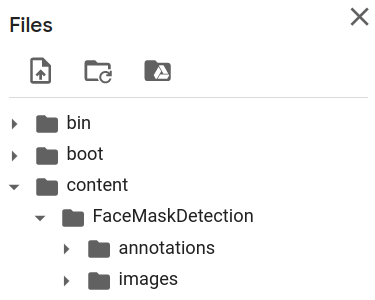


Вам предлагается выбрать любой репозиторий для детекции объектов (или написать весь пайплайн самим) и обучить модель детектровать лица и определять, есть ли на них маска.  Всего в датасете 3 класса: 
- лицо без маски
- лицо в маске
- лицо с неправильно надетой маской

Последний класс при желании можете считать за лицо без маски, так как таких озображений достаточно мало плюс они не очень сильно отличаются от лица без маски. Поэтому, для упрощения задачи можете редуцировать количество классов до 2. Но это по желанию. 

Для выполнения задания вам необходимо обучить модель для детекции объектов, чтобы метрика mAP была больше 0.5. А также необходимо продемонстрировать, что помимо обучения модели вы умеете ей пользоваться, и она выдает адекватные результаты. 

Для этого сделаем следующее: ниже представлен сниппет кода, который позволяет сохранить в collab-е снимок с камеры. Если запустим данный код, то получим следующее:

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


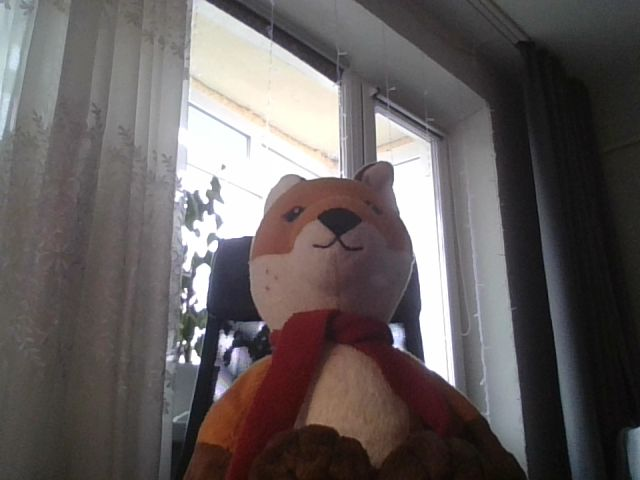

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Изображение сохранилось под именем `photo.jpg`. Теперь мы его можем открыть при помощи opencv и посмотреть на него уже из python-кода.

In [ ]:
 import cv2
 import matplotlib.pyplot as plt


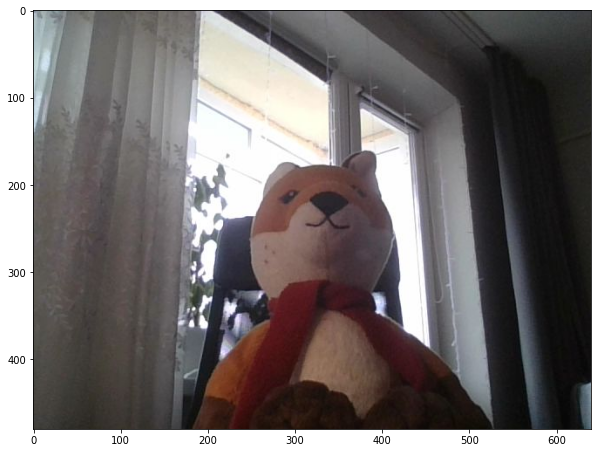

In [ ]:
PATH_TO_SAVED_IMAGE = './photo.jpg'

image = cv2.imread(PATH_TO_SAVED_IMAGE)
image = image[:,:,::-1]

plt.figure(figsize=(10, 10))
plt.imshow(image)

На изображении выше представлен хитрый лис, но в вашем случае там будете сидеть вы. Если у вас нет веб-камеры или вы стесняетесь фотографировать себя, то можно скачать картинку из интернета или использовать любую из тестового набора данных (ни в коем случае не из тренировочного).

Далее надо сделать следующее: примените детектор к изображению. Он должен найти на нем bounding box определенного класса. Нас интересуют только лица с масками и без масок. После того, как бокс найден давайте заменим лицо внутри него на соответствующее эмодзи. Я скачал парочку из интернета: эмодзи с маской на лице и без нее.

Выполним код снизу, он загрузит два изображения эмодзи.

In [ ]:
!gdown "https://drive.google.com/uc?export=download&id=1TGKGK78czrPWNWcxNOYaLbaFGTuelpfs"
!gdown "https://drive.google.com/uc?export=download&id=14hmxOrKEf-nC0o7SK2bgo5cjNOv_3mDZ"

Downloading...
From: https://drive.google.com/uc?export=download&id=1TGKGK78czrPWNWcxNOYaLbaFGTuelpfs
To: /content/mask.png
100% 43.5k/43.5k [00:00<00:00, 16.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=14hmxOrKEf-nC0o7SK2bgo5cjNOv_3mDZ
To: /content/without_mask.png
100% 1.57M/1.57M [00:00<00:00, 49.7MB/s]


В папке content появились два изображения: `mask.png` и `without_mask.png`.

Теперь давайте представим, что у меня уже есть детекция мордочки хитрого лиса (я просто сам выбрал координаты), и моделька решила, что он без маски. Код ниже позволяет отобразить эмодзи без маски на изображении.

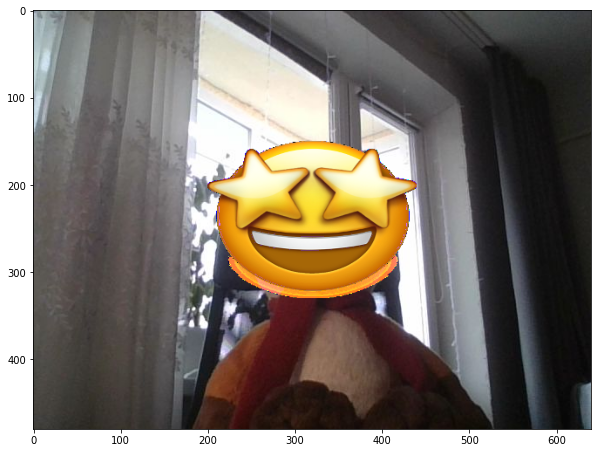

In [ ]:
# определим пути к изображениям
PATH_TO_SAVED_IMAGE = './photo.jpg'
PATH_TO_IMAGE_WITH_MASK = './mask.png'
PATH_TO_IMAGE_WITHOUT_MASK = './without_mask.png'

# считываем изображения и сразу меняем BGR -> RGB
image = cv2.imread(PATH_TO_SAVED_IMAGE)[:,:,::-1]
emoji_mask = cv2.imread(PATH_TO_IMAGE_WITH_MASK)[:,:,::-1]
emoji_without_mask = cv2.imread(PATH_TO_IMAGE_WITHOUT_MASK)[:,:,::-1]


#определяем функцию для отрисовки данных
def draw_emoji_over_face(image, bbox, emoji_image):
    image_to_draw = image.copy()
    emojy_to_draw = cv2.resize(emoji_image, (bbox[2] - bbox[0], bbox[3] - bbox[1]))
    face_crop = image_to_draw[bbox[1]: bbox[3], bbox[0]: bbox[2]]
    face_crop[emojy_to_draw != 0] = emojy_to_draw[emojy_to_draw != 0]

    return image_to_draw

# бокс в формате x_tl, y_tl, x_br, y_br
bbox = [200, 150, 440, 330]

# отрисовываем эмодзи
image_without_mask = draw_emoji_over_face(image, bbox, emoji_without_mask)

# Отрисовываем изображение
plt.figure(figsize=(10, 10))
plt.imshow(image_without_mask)

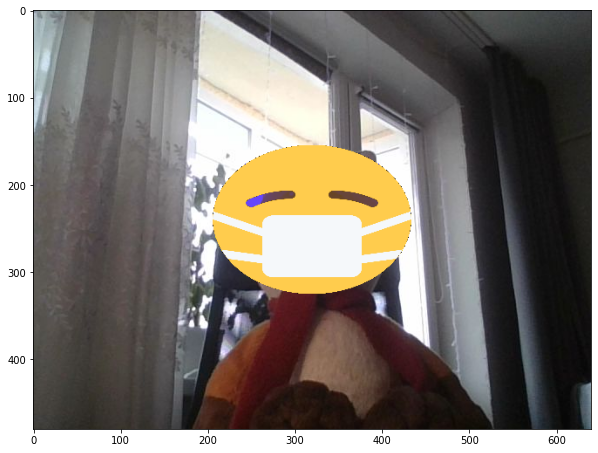

In [ ]:
# отрисовываем эмодзи
image_with_mask = draw_emoji_over_face(image, bbox, emoji_mask)

# Отрисовываем изображение
plt.figure(figsize=(10, 10))
plt.imshow(image_with_mask)